## GeoCroissant to OGC-TDML Converter
<img src="GeoCroissant.jpg" alt="GeoCroissant" width="150" style="float: right; margin-left: 20px;"/>

This notebook demonstrates how to convert a dataset from the [GeoCroissant](https://github.com/mlcommons/croissant) JSON-LD format to the [OGC-TDML](https://github.com/openrsgis/pytdml) format using the official pytdml library.

### **How it works:**
- **Uses pytdml library** with proper class structures for OGC-TDML compliance
- **Directly parses** the GeoCroissant JSON to extract metadata, recordSet structure, and field definitions
- **Extracts band information** from `geocr:bandConfiguration` with wavelengths and HLS band references
- **Extracts class information** from `geocr:classValues` for semantic segmentation tasks
- **Creates proper pytdml objects** using `EOTrainingDataset`, `AI_EOTask`, `AI_EOTrainingData`, etc.
- **Generates valid TDML JSON** that follows the OGC-TDML specification and can be used with pytdml's ML features

### Run the GeoCroissant to TDML Converter

The following command runs the converter script to transform your GeoCroissant JSON file into a TDML-compliant JSON file.

```bash
!python geocroissant_to_ogc-tdml_converter.py croissant.json croissant_to_ogctdml.json
```

- **Input:** `croissant.json` (GeoCroissant format)
- **Output:** `croissant_to_ogctdml.json` (TDML format)

This step ensures your dataset is ready for use in ML workflows that require the TDML format.
```

In [ ]:
!pip install https://github.com/openrsgis/pytdml/releases/download/v1.2.0/pytdml-1.2.0-py3-none-any.whl
!pip install mlcroissant s3fs requests

In [1]:
!python geocroissant_to_ogc-tdml_converter.py croissant.json croissant_to_ogctdml.json

TDML file written to croissant_to_ogctdml.json
Converted dataset: HLS_Burn_Scars
Total samples: 804
Training samples: 540
Validation samples: 264
Classes: 3
Bands: 6
Data entries: 50


### Load and Inspect the OGC-TDML Dataset

This code loads the generated TDML file using `pytdml` and prints key dataset information:

- **Purpose:**  
  - Verifies that the TDML file is valid and can be loaded.
  - Displays the dataset name, number of training samples, and number of classes.
- **Expected Output:**  
  - The correct dataset name.
  - The total number of image/mask pairs.
  - The number of semantic classes in the dataset.

In [2]:
import pytdml.io

training_dataset = pytdml.io.read_from_json(
    "croissant_to_ogctdml.json"
)  # read from TDML json file
print("Load training dataset: " + training_dataset.name)
print("Number of training samples: " + str(training_dataset.amount_of_training_data))
print("Number of classes: " + str(training_dataset.number_of_classes))

Load training dataset: HLS_Burn_Scars
Number of training samples: 50
Number of classes: 3


In [3]:
!mlcroissant validate --jsonld=croissant.json

I0902 18:53:45.755926 134339683443072 validate.py:53] Done.


## Loading and Visualizing a TDML Segmentation Dataset with GDAL and PyTorch

This example demonstrates how to load a segmentation dataset described by a TDML (Training Data Markup Language) JSON file, download the image and mask pairs, and visualize them using PyTorch, GDAL, and Matplotlib.

**Notes:**
- This class will automatically download and cache the images and masks locally.
- The image and mask are loaded using GDAL, supporting multi-band geospatial TIFFs.
- The mask is assumed to be the first label in the `labels` list for each data entry.
- Adjust the TDML file path as needed for your dataset.

Found 50 image/mask pairs in the dataset
First image URL: https://huggingface.co/datasets/harshinde/hls_burn_scars/resolve/main/training/subsetted_512x512_HLS.S30.T10SDH.2020248.v1.4_merged.tif
First mask URL: https://huggingface.co/datasets/harshinde/hls_burn_scars/resolve/main/training/subsetted_512x512_HLS.S30.T10SDH.2020248.v1.4.mask.tif
Downloading: https://huggingface.co/datasets/harshinde/hls_burn_scars/resolve/main/training/subsetted_512x512_HLS.S30.T10SDH.2020248.v1.4_merged.tif


Downloading: https://huggingface.co/datasets/harshinde/hls_burn_scars/resolve/main/training/subsetted_512x512_HLS.S30.T10SDH.2020248.v1.4.mask.tif
Image shape: torch.Size([6, 512, 512])
Mask shape: torch.Size([512, 512])


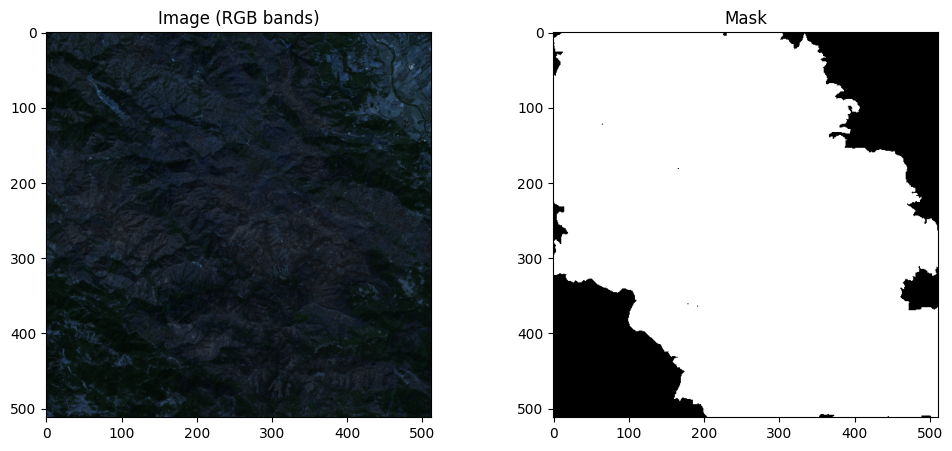

In [6]:
import os
import requests
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from osgeo import gdal
import json
import matplotlib.pyplot as plt


class TDMLSegmentationDatasetGDAL(Dataset):
    def __init__(self, tdml_path, transform=None, cache_dir="./cache"):
        with open(tdml_path) as f:
            tdml = json.load(f)
        self.data = tdml["data"]
        self.transform = transform
        self.cache_dir = cache_dir
        os.makedirs(self.cache_dir, exist_ok=True)

        # Pair image and mask URLs
        self.pairs = []
        for entry in self.data:
            img_url = entry.get("dataURL", [None])[0]  # Updated: dataURL (camelCase)
            mask_url = None
            # Look for AI_PixelLabel in the labels array
            if entry.get("labels"):
                for label in entry["labels"]:
                    if label.get("type") == "AI_PixelLabel" and label.get("imageURL"):
                        mask_url = label["imageURL"][0]
                        break
            if img_url and mask_url:
                self.pairs.append((img_url, mask_url))

        print(f"Found {len(self.pairs)} image/mask pairs in the dataset")
        if len(self.pairs) > 0:
            print(f"First image URL: {self.pairs[0][0]}")
            print(f"First mask URL: {self.pairs[0][1]}")

    def _download(self, url_or_path):
        # Handle both URLs and local file paths
        if url_or_path.startswith(("http://", "https://")):
            # Download from URL
            filename = os.path.join(self.cache_dir, os.path.basename(url_or_path))
            if not os.path.exists(filename):
                print(f"Downloading: {url_or_path}")
                r = requests.get(url_or_path)
                r.raise_for_status()
                with open(filename, "wb") as f:
                    f.write(r.content)
            return filename
        else:
            # Local file path - check if it exists
            if os.path.exists(url_or_path):
                return url_or_path
            else:
                print(f"Warning: Local file not found: {url_or_path}")
                return url_or_path  # Return anyway for debugging

    def _load_image(self, path):
        ds = gdal.Open(path)
        if ds is None:
            raise RuntimeError(f"GDAL could not open {path}")
        bands = []
        for i in range(1, ds.RasterCount + 1):
            band = ds.GetRasterBand(i).ReadAsArray()
            bands.append(band)
        img = np.stack(bands, axis=-1)  # (H, W, bands)
        return img

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_url, mask_url = self.pairs[idx]
        img_path = self._download(img_url)
        mask_path = self._download(mask_url)
        img = self._load_image(img_path)
        mask = self._load_image(mask_path)
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img).permute(2, 0, 1).float()  # (C, H, W)
        mask = torch.from_numpy(mask).long()
        if mask.ndim == 3:
            mask = mask.squeeze()
        return img, mask


# Usage example:
dataset = TDMLSegmentationDatasetGDAL("croissant_to_ogctdml.json", transform=None)
img, mask = dataset[0]
print("Image shape:", img.shape)
print("Mask shape:", mask.shape)

# Plotting
img_np = img.permute(1, 2, 0).numpy()
mask_np = mask.numpy()
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
if img_np.shape[2] >= 3:
    plt.imshow(img_np[:, :, :3] / np.max(img_np[:, :, :3]))
    plt.title("Image (RGB bands)")
else:
    plt.imshow(img_np[:, :, 0], cmap="grey")
    plt.title("Image (Band 1)")
plt.axis("on")
plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap="grey", vmin=0, vmax=1)
plt.title("Mask")
plt.axis("on")
plt.show()